### Importazione librerie

In [ ]:
import pandas as pd
import numpy as np
import ccxt
from ta.volatility import AverageTrueRange
from ta.momentum import RSIIndicator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, r2_score
warnings.filterwarnings('ignore')

### Raccolta dati
Utilizziamo la funzione download_and_plot per scaricare i dati di Bitcoin da Bybit per il 2024 con timeframe di 1 minuto e li salviamo in un DataFrame.

In [4]:
def download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot):
    exchange_class = getattr(ccxt, market)
    exchange = exchange_class()
    exchange.load_markets()
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)
    data_frames = {}
    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su {market}.")
        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        ohlcv = []
        since = start_timestamp
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1
            time.sleep(exchange.rateLimit / 1000)
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df
    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [5]:
# Parametri per il download
cryptos = ['BTC']
market = 'bybit'
timeframe_download = '1m'
start_date = '2024-01-01'
end_date = '2024-12-31'
plot = False  # Imposta a True se vuoi visualizzare i grafici

# Scarica i dati
data = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot)
btc_df = data['BTC']

# Visualizza le prime righe per controllo
btc_df

Scarico i dati per BTC/USDT dal 2024-01-01 al 2024-12-31...


,open,high,low,close,volume
timestamp,,,,,
2024-01-01 00:00:00,42284.00,42300.00,42260.01,42300.00,15.059749
2024-01-01 00:01:00,42300.00,42321.99,42299.99,42320.28,4.240722
2024-01-01 00:02:00,42320.28,42335.79,42317.30,42322.57,5.671511
2024-01-01 00:03:00,42322.57,42370.00,42322.57,42366.50,6.801620
2024-01-01 00:04:00,42366.50,42399.68,42366.50,42399.68,6.264730
...,...,...,...,...,...
2024-12-30 23:56:00,92816.59,92878.51,92789.85,92870.74,6.900125
2024-12-30 23:57:00,92870.74,92895.11,92838.44,92844.67,6.369311
2024-12-30 23:58:00,92844.67,92845.68,92797.10,92831.16,6.396956


### Feature engineering
Calcoliamo le feature richieste: ATR, RSI, medie mobili semplici (SMA) ed esponenziali (EMA), deviazioni standard mobili, minimi e massimi mobili, sia sui prezzi che sulle variazioni percentuali. Aggiungiamo anche le derivate prima, seconda e terza.

In [ ]:
def calculate_indicators(df, windows, atr_window, rsi_window):
    price_types = ['open', 'high', 'low', 'close']

    # Calcolo della variazione percentuale
    for price_type in price_types:
        df[f'pct_change_{price_type}'] = df[price_type].pct_change()
    
    # Indicatori sui prezzi di chiusura
    df['ATR'] = AverageTrueRange(df['high'], df['low'], df['close'], window=atr_window).average_true_range()
    for price_type in price_types:
        df[f'RSI_{price_type}'] = RSIIndicator(df[price_type], window=rsi_window).rsi()
    
    for window in windows:
        for price_type in price_types:
            df[f'SMA_{price_type}_{window}'] = df[price_type].rolling(window=window).mean()
            df[f'EMA_{price_type}_{window}'] = df[price_type].ewm(span=window, adjust=False).mean()
            df[f'STD_{price_type}_{window}'] = df[price_type].rolling(window=window).std()
            df[f'MIN_{price_type}_{window}'] = df[price_type].rolling(window=window).min()
            df[f'MAX_{price_type}_{window}'] = df[price_type].rolling(window=window).max()
            
            # Indicatori sulle variazioni percentuali
            df[f'SMA_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).mean()
            df[f'EMA_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].ewm(span=window, adjust=False).mean()
            df[f'STD_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).std()
            df[f'MIN_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).min()
            df[f'MAX_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).max()
    
    # Calcolo delle derivate
    feature_cols = [col for col in df.columns]
    for col in feature_cols:
        df[f'{col}_diff1'] = df[col].diff()
        df[f'{col}_diff2'] = df[col].diff().diff()
        df[f'{col}_diff3'] = df[col].diff().diff().diff()
    
    return df

,open,high,low,close,volume,pct_change_open,pct_change_high,pct_change_low,pct_change_close,ATR,...,EMA_PCT_close_1440_diff3,STD_PCT_close_1440_diff1,STD_PCT_close_1440_diff2,STD_PCT_close_1440_diff3,MIN_PCT_close_1440_diff1,MIN_PCT_close_1440_diff2,MIN_PCT_close_1440_diff3,MAX_PCT_close_1440_diff1,MAX_PCT_close_1440_diff2,MAX_PCT_close_1440_diff3
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-02 00:03:00,44170.00,44211.99,44160.12,44211.99,4.904479,-0.001086,-0.000272,0.000087,0.000951,42.062317,...,5.719165e-06,-1.324293e-07,-1.111323e-06,-1.514164e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-02 00:04:00,44211.99,44269.19,44195.30,44269.19,19.361744,0.000951,0.001294,0.000797,0.001294,44.335723,...,-2.353758e-06,8.089450e-07,9.413743e-07,2.052698e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-02 00:05:00,44269.19,44329.45,44269.19,44329.45,21.537676,0.001294,0.001361,0.001672,0.001361,45.473171,...,-3.832688e-07,1.358846e-06,5.499005e-07,-3.914739e-07,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-02 00:06:00,44329.45,44438.31,44320.96,44363.00,78.146528,0.001361,0.002456,0.001169,0.000757,50.607230,...,-9.325838e-07,3.256073e-07,-1.033238e-06,-1.583139e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-02 00:07:00,44363.00,44444.88,44324.28,44435.29,32.539819,0.000757,0.000148,0.000075,0.001630,55.606714,...,2.051219e-06,1.928403e-06,1.602796e-06,2.636034e-06,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:56:00,92816.59,92878.51,92789.85,92870.74,6.900125,0.000446,0.000181,0.000157,0.000583,70.594824,...,-5.147640e-07,1.379089e-07,1.459830e-07,1.510800e-07,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-30 23:57:00,92870.74,92895.11,92838.44,92844.67,6.369311,0.000583,0.000179,0.000524,-0.000281,69.600194,...,-1.390728e-06,-7.049482e-08,-2.084038e-07,-3.543868e-07,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-30 23:58:00,92844.67,92845.68,92797.10,92831.16,6.396956,-0.000281,-0.000532,-0.000445,-0.000146,68.098751,...,1.388651e-06,-1.848873e-07,-1.143925e-07,9.401123e-08,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Parametri regolabili
windows = [5, 10, 60, 100, 720, 1000, 1440] # Finestre per gli indicatori
atr_window = 14
rsi_window = 14 

# Calcola le feature
btc_df = calculate_indicators(btc_df, windows, atr_window, rsi_window)

# Rimuovi i NaN generati dai calcoli
btc_df = btc_df.dropna()

# Visualizza le prime righe per controllo
btc_df

### Preparazione dei dati
Raggruppiamo i dati per giorno, li mischiamo casualmente e li dividiamo in train, validation e test sets.

In [28]:
def prepare_data(df, F, train_size=0.7, val_size=0.2):
    
    test_size = 1 - train_size - val_size
    
    # Target: prezzo dopo F candele
    X = df.drop(columns=['close'])
    # y = df['close'].shift(-F)
    y = df['close'].shift(-5) - df['close'] # Come target uso la variazione del prezzo anzichè il prezzo per evitare il "bias del valore corrente"
    
    # Rimuovi le ultime F righe dove y è NaN
    X = X.iloc[:-F]
    y = y.iloc[:-F]
    
    # Raggruppamento per giorno
    dates = X.index.date
    unique_dates = np.unique(dates)
    
    # Ordina i giorni in ordine cronologico
    unique_dates = np.sort(unique_dates)
    
    # Calcola il numero di giorni per il test set (ultimi giorni)
    n_test = int(test_size * len(unique_dates))
    test_dates = unique_dates[-n_test:]
    
    # Giorni rimanenti per train e validation
    remaining_dates = unique_dates[:-n_test]
    
    # Mischia casualmente i giorni rimanenti
    np.random.shuffle(remaining_dates)
    
    # Calcola il numero di giorni per train e validation
    n_train = int(train_size * len(remaining_dates))
    train_dates = remaining_dates[:n_train]
    val_dates = remaining_dates[n_train:]
    
    # Creazione dei set
    date_index = pd.Index(X.index.date)  # Converti in pd.Index
    X_train = X[date_index.isin(train_dates)]
    y_train = y[date_index.isin(train_dates)]
    X_val = X[date_index.isin(val_dates)]
    y_val = y[date_index.isin(val_dates)]
    X_test = X[date_index.isin(test_dates)]
    y_test = y[date_index.isin(test_dates)]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [29]:
# Parametri regolabili
F = 5  # Numero di candele avanti da prevedere
train_size = 0.7  # 70% dei giorni rimanenti per il train
val_size = 0.2  # 20% dei giorni rimanenti per la validation

# Prepara i dati (assumendo che btc_df sia il DataFrame con i dati)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(btc_df, F, train_size, val_size)

# Controllo delle dimensioni
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (329757, 1175), Validation: (142560, 1175), Test: (51836, 1175)


### Costruzione e addestramento dei modelli
Costruiamo e addestriamo un modello Random Forest e una rete neurale

#### Random forest

In [ ]:
rf_model = RandomForestRegressor(
        n_estimators=100,
        criterion='squared_error',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features='sqrt',
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=42,
        verbose=2,
        warm_start=False,
        ccp_alpha=0.0,
        max_samples=None,
    )

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

R^2 (test):  0.4999
RMSE (test): 2386.0796

Feature Importances (valore assoluto e percentuale):


,feature,importance_pct
34,EMA_low_5,3.865422e+00
1,high,3.628014e+00
0,open,3.406247e+00
44,EMA_close_5,3.137947e+00
26,MIN_high_5,2.908581e+00
...,...,...
1083,MAX_PCT_open_1440_diff2,3.784861e-08
869,MIN_PCT_high_720_diff1,3.661887e-08
1082,MAX_PCT_open_1440_diff1,3.095329e-08
1109,MIN_PCT_high_1440_diff1,2.621140e-08


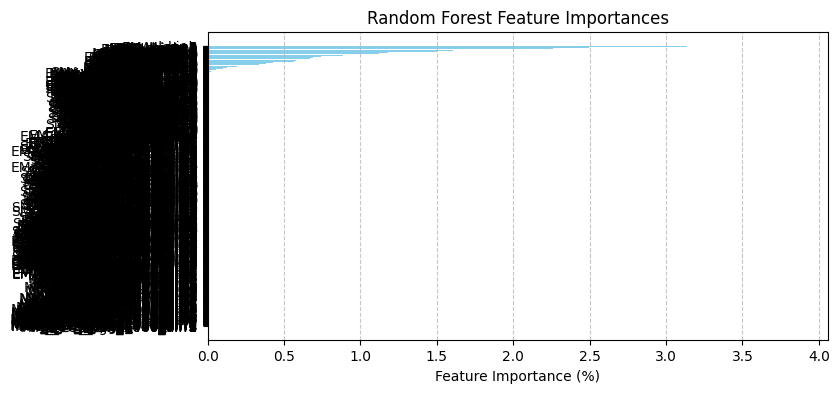

In [ ]:
# Metriche di valutazione
r2 = r2_score(y_test, rf_pred)
rmse = mean_squared_error(y_test, rf_pred, squared=False)

print(f"R^2 (test):  {r2:.4f}")
print(f"RMSE (test): {rmse:.4f}")

# Feature importances
importances = rf_model.feature_importances_
importances_pct = 100.0 * (importances / importances.sum())

feats_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance_pct': importances_pct
}).sort_values('importance_pct', ascending=True)

print("\nFeature Importances (valore percentuale):")
display(feats_imp.sort_values('importance_pct', ascending=False))

# Plot orizzontale delle importanze (percentuali)
plt.figure(figsize=(8, 4))
plt.barh(feats_imp['feature'], feats_imp['importance_pct'], color='skyblue')
plt.xlabel('Feature Importance (%)')
plt.title('Random Forest Feature Importances')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Rete neurale

In [ ]:
def train_neural_network_regressor(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    network_width: int = 64,
    network_depth: int = 3,
    activation_function: str = 'relu',
    patience: int = 10,
    epochs: int = 100,
    batch_size: int = 32,
    monitor: str = 'val_loss',
    loss: str = 'mse'
):
    """
    Allena una rete neurale per predire un valore continuo (target) a partire dalle feature.
    I dati di train, validation e test sono forniti come input già preparati.

    Parametri
    ----------
    X_train : pd.DataFrame
        Feature del training set.
    y_train : pd.Series
        Target del training set.
    X_val : pd.DataFrame
        Feature del validation set.
    y_val : pd.Series
        Target del validation set.
    X_test : pd.DataFrame
        Feature del test set.
    y_test : pd.Series
        Target del test set.
    network_width : int, default 64
        Numero di neuroni in ogni strato hidden.
    network_depth : int, default 3
        Numero di strati hidden.
    activation_function : str, default 'relu'
        Funzione di attivazione da usare nei layer hidden.
    patience : int, default 10
        Numero di epoche da attendere prima di fermare l’allenamento (early stopping).
    epochs : int, default 100
        Numero massimo di epoche per l’allenamento.
    batch_size : int, default 32
        Dimensione del batch per l’allenamento.
    monitor : str, default 'val_loss'
        Metrica da monitorare per l'early stopping.
    loss : str, default 'mse'
        Funzione di loss da usare.

    Ritorna
    -------
    model : tf.keras.Model
        Il modello neurale addestrato.
    history : tf.keras.callbacks.History
        L’oggetto history con le metriche di training.
    metrics_dict : dict
        Dizionario con MAE, MAPE e loss su train, validation e test.
    """
    # Conversione a NumPy array per Keras
    X_train_np = X_train.values
    y_train_np = y_train.values
    X_val_np = X_val.values
    y_val_np = y_val.values
    X_test_np = X_test.values
    y_test_np = y_test.values

    # Costruzione del modello
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train_np.shape[1],)))
    for _ in range(network_depth):
        model.add(Dense(network_width, activation=activation_function))
    # Output: 1 neurone con attivazione lineare per regressione
    model.add(Dense(1, activation='linear'))

    # Compilazione del modello
    model.compile(optimizer='adam', loss=loss, metrics=['mae', 'mape'])

    # Configurazione dell'early stopping
    early_stop = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

    # Addestramento del modello
    history = model.fit(
        X_train_np, y_train_np,
        validation_data=(X_val_np, y_val_np),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    # Valutazione sui tre set
    train_loss, train_mae, train_mape = model.evaluate(X_train_np, y_train_np, verbose=0)
    val_loss, val_mae, val_mape = model.evaluate(X_val_np, y_val_np, verbose=0)
    test_loss, test_mae, test_mape = model.evaluate(X_test_np, y_test_np, verbose=0)

    # Creazione del dizionario delle metriche
    metrics_dict = {
        'train_loss': train_loss,
        'train_mae': train_mae,
        'train_mape': train_mape,
        'val_loss': val_loss,
        'val_mae': val_mae,
        'val_mape': val_mape,
        'test_loss': test_loss,
        'test_mae': test_mae,
        'test_mape': test_mape
    }

    # Grafici di training
    epochs_range = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(18, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    # MAE
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history.history['mae'], label='Train MAE')
    plt.plot(epochs_range, history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    # MAPE
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history.history['mape'], label='Train MAPE')
    plt.plot(epochs_range, history.history['val_mape'], label='Validation MAPE')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.title('MAPE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("Metriche finali:")
    print(metrics_dict)

    return model, history, metrics_dict

Epoch 1/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - loss: 213185200.0000 - mae: 6354.9888 - mape: 10.1909 - val_loss: 71629.8047 - val_mae: 189.7426 - val_mape: 0.3015
Epoch 2/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 88091.3984 - mae: 204.2569 - mape: 0.3292 - val_loss: 61111.1523 - val_mae: 175.7196 - val_mape: 0.2789
Epoch 3/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 76552.2188 - mae: 190.4256 - mape: 0.3071 - val_loss: 52693.4492 - val_mae: 163.4228 - val_mape: 0.2593
Epoch 4/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 66070.8906 - mae: 177.1886 - mape: 0.2855 - val_loss: 45107.3867 - val_mae: 151.0124 - val_mape: 0.2401
Epoch 5/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 56438.0000 - mae: 163.2372 - mape: 0.2631 - val_loss: 39836.7227 - val_mae: 142.9001 - val_mape: 0.2277
Epoch 6/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 47008.3242 - mae: 148.8988 - mape: 0.2402 - val_loss: 35608.2305 - val_mae: 137.9174

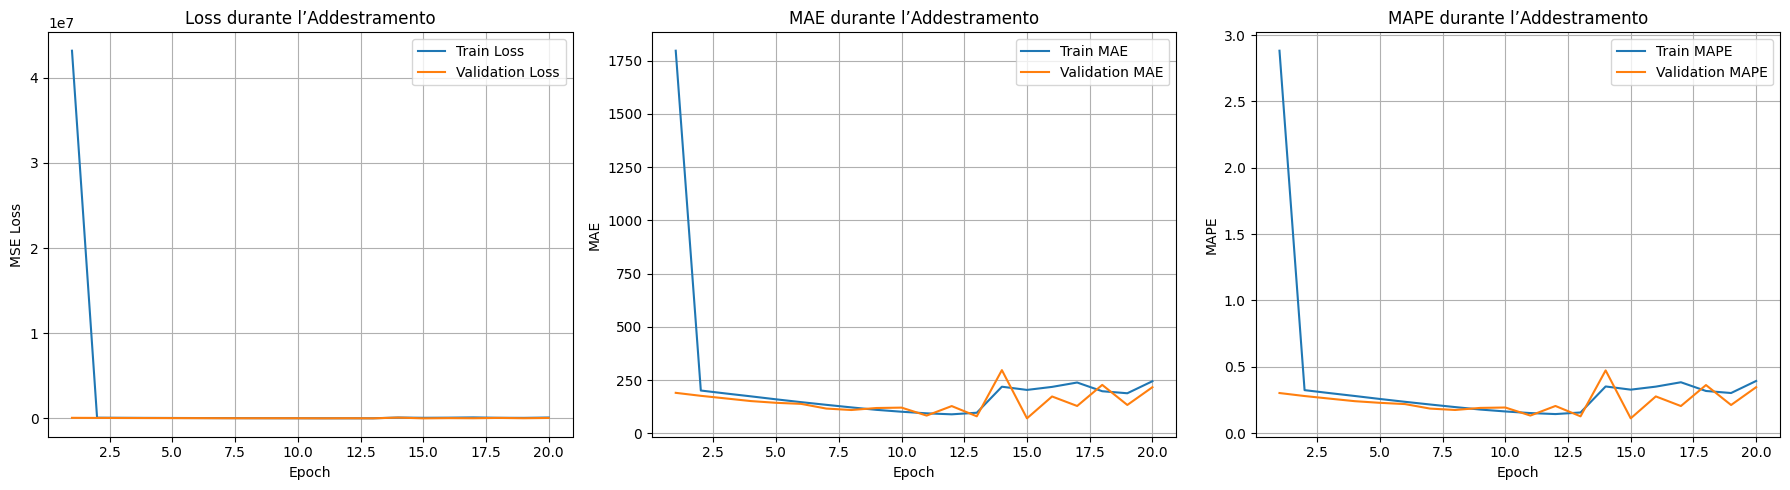

Metriche finali:
{'train_loss': 13437.9873046875, 'train_mae': 76.12911224365234, 'train_mape': 0.12221865355968475, 'val_loss': 11272.6552734375, 'val_mae': 69.983154296875, 'val_mape': 0.11071325838565826, 'test_loss': 31161.751953125, 'test_mae': 123.25159454345703, 'test_mape': 0.1258843094110489}


In [ ]:
model, history, metrics_dict = train_neural_network_regressor(
    X_train, y_train, X_val, y_val, X_test, y_test,
    network_width=64,
    network_depth=3,
    activation_function='relu',
    patience=5,
    epochs=10000,
    batch_size=1024,
    monitor='val_loss',
    loss='rmse'
)

In [ ]:
# Ottieni le predizioni sul test set
predicted_change = model.predict(X_test)
nn_pred = predicted_change.flatten()
predicted_price = X_test['close'] + predicted_change

1620/1620 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


In [ ]:
# Accuratezza direzionale
np.mean(np.sign(predicted_change) == np.sign(y_test))

#### LSTM

In [ ]:
def create_sequences(X, y, lookback, forecast_horizon=1):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X) - forecast_horizon):
        X_seq.append(X.iloc[i - lookback:i].values)
        y_seq.append(y.iloc[i + forecast_horizon])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
def train_lstm_model(
    X_train, y_train, X_val, y_val, X_test, y_test,
    lookback=10,              # Finestra temporale di input
    forecast_horizon=1,       # Orizzonte di previsione
    lstm_units=50,            # Numero di unità nel layer LSTM
    num_layers=1,             # Numero di layer LSTM
    dropout_rate=0.2,         # Percentuale di dropout
    dense_units=10,           # Unità nel layer denso aggiuntivo (opzionale)
    use_bidirectional=False,  # Usa LSTM bidirezionale
    activation='tanh',        # Funzione di attivazione per LSTM
    recurrent_activation='sigmoid',  # Attivazione ricorrente
    epochs=100,               # Numero massimo di epoche
    batch_size=32,            # Dimensione del batch
    learning_rate=0.001,      # Tasso di apprendimento
    patience=10,              # Pazienza per early stopping
    optimizer='adam',         # Ottimizzatore
    loss_function='mse'       # Funzione di perdita
):
    # Creare le sequenze per train, validation e test
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, lookback, forecast_horizon)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, lookback, forecast_horizon)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, lookback, forecast_horizon)
    
    # Costruire il modello LSTM
    model = Sequential()
    
    # Aggiungere layer LSTM
    for i in range(num_layers):
        if i == 0:
            # Primo layer (specifica input_shape)
            if use_bidirectional:
                model.add(Bidirectional(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(num_layers > 1),
                    input_shape=(lookback, X_train.shape[1])
                )))
            else:
                model.add(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(num_layers > 1),
                    input_shape=(lookback, X_train.shape[1])
                ))
        else:
            # Layer successivi
            if use_bidirectional:
                model.add(Bidirectional(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(i < num_layers - 1)
                )))
            else:
                model.add(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(i < num_layers - 1)
                ))
    
    # Aggiungere dropout
    model.add(Dropout(dropout_rate))
    
    # Aggiungere un layer denso opzionale
    if dense_units > 0:
        model.add(Dense(units=dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Layer di output
    model.add(Dense(1))  # Per regressione (un valore continuo)

    # Configurare l'ottimizzatore
    if optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = optimizer  # Permette di passare un ottimizzatore personalizzato

    # Compilare il modello
    model.compile(optimizer=opt, loss=loss_function)

    # Configurare l'early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Addestrare il modello
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    # Predizioni sul test set
    lstm_pred = model.predict(X_test_seq).flatten()

    # Calcolare le metriche
    lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_pred))
    lstm_mae = mean_absolute_error(y_test_seq, lstm_pred)

    print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")

    return model, history, lstm_pred, y_test_seq, lstm_rmse, lstm_mae

In [ ]:
# Parametri per l'LSTM
lookback = 10
forecast_horizon = 5
lstm_units = 50
num_layers = 1
dropout_rate = 0.2
dense_units = 10
use_bidirectional = False
activation = 'tanh'
recurrent_activation = 'sigmoid'
epochs = 100
batch_size = 32
learning_rate = 0.001
patience = 10
optimizer = 'adam'
loss_function = 'mse'

# Addestrare l'LSTM
lstm_model, lstm_history, lstm_pred, y_test_seq, lstm_rmse, lstm_mae = train_lstm_model(
    X_train, y_train, X_val, y_val, X_test, y_test,
    lookback=lookback,
    forecast_horizon=forecast_horizon,
    lstm_units=lstm_units,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    dense_units=dense_units,
    use_bidirectional=use_bidirectional,
    activation=activation,
    recurrent_activation=recurrent_activation,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    patience=patience,
    optimizer=optimizer,
    loss_function=loss_function
)

### Valutazione dei modelli
Valutiamo le performance dei modelli usando RMSE e MAE.

In [ ]:
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")
    return rmse, mae, mape

# Valutazione
rf_rmse, rf_mae, rf_mape = evaluate(y_test, rf_pred, "Random Forest")
nn_rmse, nn_mae, nn_mape = evaluate(y_test, nn_pred, "Neural Network")
lstm_rmse, lstm_mae, lstm_mape = evaluate(y_test_seq, lstm_pred, "LSTM")

Random Forest - RMSE: 2386.0796, MAE: 1341.6361
Neural Network - RMSE: 176.5270, MAE: 123.2516
